# Xopt Evaluator Basic Usage 

In [1]:
# needed for macos
import platform

if platform.system() == "Darwin":
    import multiprocessing as mp

    mp.set_start_method("fork")

In [2]:
from xopt import Xopt, Evaluator, Generator, VOCS
from xopt.generators.random import RandomGenerator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt.evaluator import DummyExecutor
import numpy as np
import pandas as pd
from time import sleep
from numpy.random import randint

np.random.seed(666) # for reproducibility

In [3]:
vocs = VOCS(variables={"x": [0, 1], "y": [0, 1]}, objectives={"f1": "MINIMIZE"})


def f(inputs):

    sleep(randint(1, 5)*.1)  # simulate computation time
    # Make some occasional errors
    if inputs["x"] > 0.8:
        raise ValueError("x > 0.8")

    return {"f1": inputs["x"] ** 2 + inputs["y"] ** 2}


in1 = vocs.random_inputs()

f(in1)


{'f1': 0.11401572022703582}

In [4]:
# Add in occsational errors. 
try:
    f({"x": 1, "y": 0})
except Exception as ex:
    print(f"Caught error in f: {ex}")

Caught error in f: x > 0.8


In [5]:
X = Xopt(generator=RandomGenerator(vocs), evaluator=Evaluator(function=f), vocs=vocs)

# Submit to the evaluator some new inputs
X.submit_data(vocs.random_inputs(4))

# Unevaluated inputs are collected in a dataframe
X._input_data

,x,y


In [6]:
# Internal futures dictionary
X._futures

{}

In [7]:
# Collect all finished futures and updata dataframe
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
1,0.272142,0.951187,0.978818,False,
2,0.048542,0.900071,0.812485,False,
3,0.987297,0.491934,NaN,True,"Traceback (most recent call last):\n File ""/U..."
4,0.586412,0.799752,0.983483,False,


In [8]:
# Futures are now cleared out
X._futures

{}

In [9]:
# This is the internal counter
X._ix_last

4

In [10]:
X.submit_data(vocs.random_inputs(4))
X._input_data

,x,y


In [11]:
X._futures

{}

In [12]:
# Singe generation step
X.step()
X.update_data()
X.data

,x,y,f1,xopt_error,xopt_error_str
1,0.272142,0.951187,0.978818,False,
2,0.048542,0.900071,0.812485,False,
3,0.987297,0.491934,NaN,True,"Traceback (most recent call last):\n File ""/U..."
4,0.586412,0.799752,0.983483,False,
5,0.299155,0.887142,0.876515,False,
6,0.706772,0.889046,1.289930,False,
7,0.225521,0.752332,0.616863,False,
8,0.994891,0.976764,NaN,True,"Traceback (most recent call last):\n File ""/U..."
9,0.802497,0.090820,NaN,True,"Traceback (most recent call last):\n File ""/U..."


# Executors

In [13]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [14]:
MAX_WORKERS = 10

In [15]:
# Dask
# from dask.distributed import Client
# import logging
# client = Client( silence_logs=logging.ERROR)
# executor = client.get_executor()
# client

In [16]:
executor = ProcessPoolExecutor(max_workers=MAX_WORKERS)
executor

In [17]:
X2 = Xopt(
    generator=RandomGenerator(vocs),
    evaluator=Evaluator(function=f, executor=executor, max_workers=MAX_WORKERS),
    vocs=vocs,
)
X2.options.asynch = True

In [18]:
for _ in range(20):
    X2.step()

<AxesSubplot:xlabel='x', ylabel='y'>

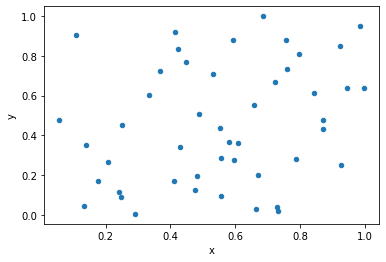

In [19]:
X2.data.plot.scatter("x", "y")

In [20]:
X2.data

,x,y,f1,xopt_error,xopt_error_str
2,0.057461,0.478903,0.232650,False,
6,0.684185,0.998964,1.466037,False,
1,0.475619,0.127120,0.242373,False,
8,0.731670,0.020664,0.535768,False,
10,0.333263,0.600748,0.471962,False,
4,0.723537,0.670598,0.973208,False,
5,0.532415,0.708698,0.785718,False,
9,0.246336,0.087637,0.068362,False,
7,0.609837,0.363820,0.504267,False,
3,0.925261,0.249796,NaN,True,concurrent.futures.process._RemoteTraceback: \...
